# Bert Tryouts with Text file #

In [1]:
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from functions_text_model import acc, f1

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)
dataloader = DataLoader(dataset, batch_size=32)
#dataset = SarcasmDataset('sarcasm_data.json')
#dataloader = DataLoader(dataset, batch_size=32)

/Users/sinarollin/opt/anaconda3/envs/DLproj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Define the evaluate function
def evaluate(model, dataloader, device):
    
    model.eval()  # Put the model in evaluation mode

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Move batch to device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # Get the loss and logits from the outputs
            loss = outputs.loss
            logits = outputs.logits

            # Add the loss to the epoch loss
            epoch_loss += loss.item()

            # Get the predictions
            preds = torch.argmax(logits, dim=1)

            # Add the predictions and labels to the epoch predictions and labels
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

    # Compute the metrics
    loss = epoch_loss / len(dataloader)
    accuracy = accuracy_score(epoch_labels, epoch_preds)
    f1 = f1_score(epoch_labels, epoch_preds, average='weighted')

    return loss, accuracy, f1


In [ ]:
def train_epoch(model, optimizer, criterion, dataloader, device):
    """This function trains the model for one epoch and returns the average loss.
    
    Parameters:
    ----------
    model: torch model
        The model to train.
    optimizer: torch optimizer
        The optimizer to use for training.
    criterion: torch loss
        The loss function to use for training.
    dataloader: torch dataloader
        The dataloader to train the model on.
    device: str
        The device to use for the training.
        
    Returns:
    -------
    epoch_loss: float
        The average loss over the epoch."""

    model.train()  # Put the model in training mode
    epoch_loss = 0

    for batch in tqdm(dataloader):
        # Move the batch to the GPU
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Compute the loss
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Zero the gradients
        optimizer.zero_grad()

        # Add the loss to the epoch loss
        epoch_loss += loss.item()

    # Compute the average loss
    epoch_loss /= len(dataloader)

    return epoch_loss


In [ ]:
# Define the number of epochs
N_EPOCHS = 5
# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}

#splitting into test and dataset

from torch.utils.data import random_split

# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Train and evaluate the model
for epoch in range(N_EPOCHS):
    # Train the model for one epoch
    train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
    print(f"Epoch {epoch+1}/{N_EPOCHS} - Train Loss: {train_loss}")

    # Evaluate the model
    eval_loss, eval_metrics_acc, eval_f1 = evaluate(model, test_dataloader, device)
    print(f"Epoch {epoch+1}/{N_EPOCHS} - Eval Loss: {eval_loss} - Metrics: {eval_metrics_acc}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 18/18 [03:45<00:00, 12.55s/it]


Epoch 1/5 - Train Loss: 0.7117744617991977


100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


Epoch 1/5 - Eval Loss: 0.7159899592399597 - Metrics: 0.4782608695652174


100%|██████████| 18/18 [07:44<00:00, 25.81s/it]


Epoch 2/5 - Train Loss: 0.6512950460116068


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Epoch 2/5 - Eval Loss: 0.6561400413513183 - Metrics: 0.6231884057971014


100%|██████████| 18/18 [02:56<00:00,  9.79s/it]


Epoch 3/5 - Train Loss: 0.5971288548575507


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 3/5 - Eval Loss: 0.6774665355682373 - Metrics: 0.6014492753623188


100%|██████████| 18/18 [10:56<00:00, 36.46s/it]


Epoch 4/5 - Train Loss: 0.4831409172879325


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 4/5 - Eval Loss: 0.7269841194152832 - Metrics: 0.6086956521739131


100%|██████████| 18/18 [03:05<00:00, 10.33s/it]


Epoch 5/5 - Train Loss: 0.4051706973049376


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]

Epoch 5/5 - Eval Loss: 0.7923229336738586 - Metrics: 0.6014492753623188


In [ ]:
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)
dataloader = DataLoader(dataset, batch_size=32)
#dataset = SarcasmDataset('sarcasm_data.json')
#dataloader = DataLoader(dataset, batch_size=32)

In [ ]:
# Define the evaluate function
def evaluate(model, dataloader, device):
    model.eval()  # Put the model in evaluation mode

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # Get the loss and logits from the outputs
            loss = outputs.loss
            logits = outputs.logits

            # Add the loss to the epoch loss
            epoch_loss += loss.item()

            # Get the predictions
            preds = torch.argmax(logits, dim=1)

            # Add the predictions and labels to the epoch predictions and labels
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

    # Compute the metrics
    loss = epoch_loss / len(dataloader)
    accuracy = accuracy_score(epoch_labels, epoch_preds)
    f1 = f1_score(epoch_labels, epoch_preds, average='weighted')

    model.train()  # Put the model back in training mode

    return loss, accuracy, f1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 5/5: 100%|██████████| 22/22 [03:01<00:00,  8.25s/it]


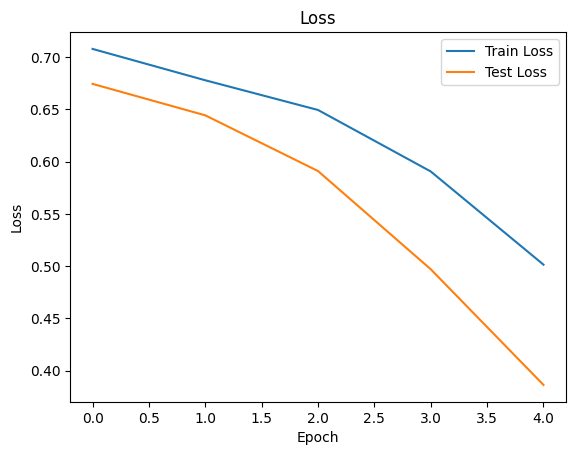

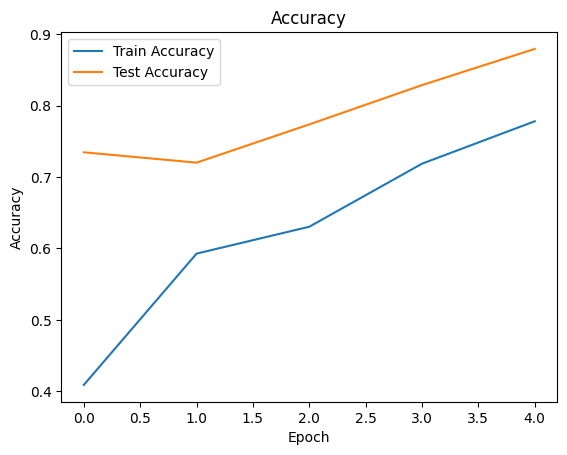

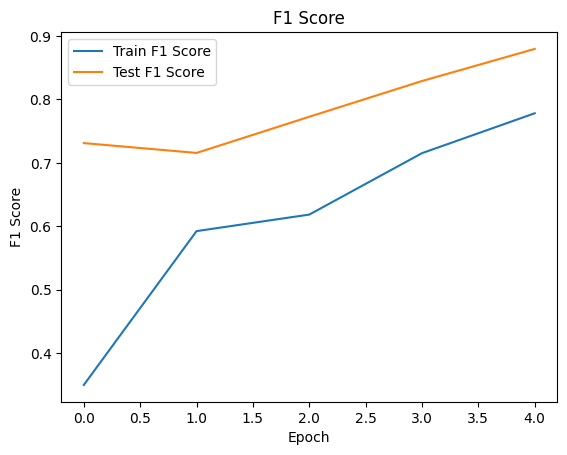

In [ ]:

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Initialize lists to store metrics for each epoch
train_losses = []
train_accuracies = []
train_f1_scores = []
test_losses = []
test_accuracies = []
test_f1_scores = []

# Training loop
epochs = 5

for epoch in range(epochs):
    epoch_loss = 0  # Initialize loss for this epoch
    epoch_preds = []  # Initialize predictions for this epoch
    epoch_labels = []  # Initialize labels for this epoch

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move batch to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Get the loss and logits from the outputs
        loss = outputs.loss
        logits = outputs.logits

        # Add the loss to the epoch loss
        epoch_loss += loss.item()

        # Get the predictions
        preds = torch.argmax(logits, dim=1)

        # Add the predictions and labels to the epoch predictions and labels
        epoch_preds.extend(preds.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

        # Backward pass
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()

    # After each epoch, compute the metrics and append them to their respective lists
    train_losses.append(epoch_loss / len(dataloader))
    train_accuracies.append(accuracy_score(epoch_labels, epoch_preds))
    train_f1_scores.append(f1_score(epoch_labels, epoch_preds, average='weighted'))

    # Evaluate on test data
    test_loss, test_accuracy, test_f1 = evaluate(model, dataloader, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)

# After all epochs, plot the metrics
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(test_f1_scores, label='Test F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
print(test_accuracies)

[0.7347826086956522, 0.7202898550724638, 0.7739130434782608, 0.8289855072463768, 0.8797101449275362]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


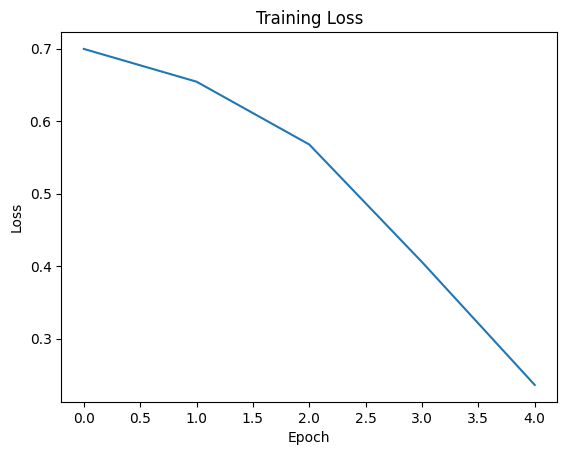

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Initialize lists to store losses for each epoch
train_losses = []

# Training loop
epochs = 5
for epoch in range(epochs):
    epoch_loss = 0  # Initialize loss for this epoch
    for batch in dataloader:
        # Move batch to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Get the loss from the outputs
        loss = outputs.loss

        # Add the loss to the epoch loss
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()

    # After each epoch, append the average epoch loss to train_losses
    train_losses.append(epoch_loss / len(dataloader))

# After all epochs, plot the training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Put the model in evaluation mode
model.eval()

# Variables to keep track of predictions and true labels
total_preds, total_labels = [], []

# Evaluation loop
with torch.no_grad():
    for batch in dataloader:
        # Move batch to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get the predictions
        preds = torch.argmax(outputs.logits, dim=1)

        # Add the predictions and the true labels to the total
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Compute the accuracy
accuracy = (np.array(total_preds) == np.array(total_labels)).mean()
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9826086956521739


In [ ]:
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output
from matplotlib import pyplot as plt




# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        padding='max_length',
                        truncation=True,
                        #pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids[0], attention_mask[0], torch.tensor(sarcasm)
        
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)

    
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids, attention_mask, labels = zip(*batch)
    input_ids = pad_sequence([torch.tensor(b) for b in input_ids], batch_first=True)
    attention_mask = pad_sequence([torch.tensor(b) for b in attention_mask], batch_first=True)
    labels = torch.tensor(labels)
    return input_ids, attention_mask, labels

dataloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

#dataloader = DataLoader(dataset, batch_size=32)
#dataset = SarcasmDataset('sarcasm_data.json')
#dataloader = DataLoader(dataset, batch_size=32)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

In [ ]:

def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    model.train()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (input_ids, attention_mask, y_batch) in tqdm(enumerate(train_loader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        target = y_batch.to(device)
        #clean previously computed gradients
        optimizer.zero_grad()

        # forward
        outputs = model(input_ids, attention_mask=attention_mask)

        #compute predictions
        with torch.no_grad():
            _, preds = torch.max(outputs.logits, 1)

        #compute loss
        loss = criterion(outputs.logits, target)

        #do backward and oprimizer steps
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [ ]:
def evaluate(model, criterion, metrics, test_loader, device):
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (input_ids, attention_mask, y_batch) in tqdm(enumerate(test_loader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        target = y_batch.to(device)

        #forward
        outputs = model(input_ids, attention_mask=attention_mask)


        #compute loss
        loss = criterion(outputs, target)

        #compute predictions
        _, preds = torch.max(outputs, 1)

        # compute metrics
        for k in epoch_metrics.keys():
            epoch_metrics[k] += metrics[k](preds, target)

        # log loss statistics
        epoch_loss += loss.item()
        

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [ ]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [ ]:
#actually you have to use validation for each step of training, but now we will focus only on the toy example and will track the perfromance on test
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


In [ ]:
#actually you have to use validation for each step of training, but now we will focus only on the toy example and will track the perfromance on test
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 5

#train_metrics_log, test_metrics_log = train_cycle(model, optimizer, torch.nn.CrossEntropyLoss(), {'accuracy': torch.nn.functional.accuracy}, dataloader, dataloader, 5, device)
train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, dataloader, dataset, n_epochs=N_EPOCHS, device=device)

train Loss: 1.0137,  ACC: 0.5909, F1-weighted: 0.3907


0it [00:00, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#This is supposed to work to! just does not show the metrics

In [ ]:
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)
dataloader = DataLoader(dataset, batch_size=32)
#dataset = SarcasmDataset('sarcasm_data.json')
#dataloader = DataLoader(dataset, batch_size=32)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    for batch in dataloader:
        # Move batch to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Get the loss from the outputs
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/sinarollin/opt/anaconda3/envs/DLproj/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `trunc

In [ ]:
# Put the model in evaluation mode
model.eval()

# Variables to keep track of predictions and true labels
total_preds, total_labels = [], []

# Evaluation loop
with torch.no_grad():
    for batch in dataloader:
        # Move batch to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get the predictions
        preds = torch.argmax(outputs.logits, dim=1)

        # Add the predictions and the true labels to the total
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Compute the accuracy
accuracy = (np.array(total_preds) == np.array(total_labels)).mean()
print(f'Test Accuracy: {accuracy}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Test Accuracy: 0.863768115942029
